In [1]:
from pydub import AudioSegment
from scipy.io import wavfile as wav
import numpy as np
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

samplerate = 44100

## Helper functions

In [2]:
#HELPER FUNCTIONS
def correlation(K, n, lag, signal1, signal2):
    signal1 = signal1[n-K:n]
    signal2 = signal2[n-K:n]
    temp = [signal1[n]*signal2[n+lag] for n in range(K - np.abs(lag))]
    return 1/(K) * np.sum(temp)

def correlation_vector(K, n, signal1, signal2):
    v = [correlation(K, n, lag, signal1, signal2) for lag in range(K)]
    return v

def correlation_matrix_X(X, K, n):
    v = correlation_vector(K, n, X, X)
    v_r = v[::-1]
    R_x = np.array([np.concatenate((v_r[K-i:], v[1:K+1-i])) for i in range(1, K+1)])
    return R_x

def svd_max(K, X, n):
    _,s,_ = np.linalg.svd(correlation_matrix_X(X,K,n))
    return np.max(s)
    
def max_mu(X, K, rate):    
    return 2/np.max([svd_max(K, X, i) for i in range(K, len(X)-K, rate)])

def MSE(prediction, correct):
    return np.square(np.subtract(prediction,correct))

def plot_spectrum():
    fig, axs = plt.subplots(1, 1, figsize=(20, 8))
    axs.grid(True)
    axs.set_xlabel('MSE')
    axs.set_ylabel('sample number')
    axs.semilogy(10)
    axs.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
    return axs

## LMS algorithms

In [3]:
def lms(mu, K, d, x):
    #init 
    fn = np.zeros(K)
    buffer = np.zeros(K)
    e = np.zeros(len(d))
    e[0] = d[0]

    for n in range(len(d)):
        buffer = np.concatenate(([x[n]], buffer[:K-1]))
        canceller = np.inner(buffer, fn)
        output = d[n] - canceller
        fn = fn + output*mu*buffer
        e[n] = output
        
    return e

def normalized_lms(mu, K, d, x):
    #init 
    fn = np.zeros(K)
    buffer = np.zeros(K)
    e = np.zeros(len(d))
    e[0] = d[0]

    for n in range(len(d)):
        buffer = np.concatenate(([x[n]], buffer[:K-1]))
        canceller = np.inner(buffer, fn)
        output = d[n] - canceller
        norm2 = np.inner(buffer, buffer)
        fn = fn + output*mu*buffer/norm2
        e[n] = output
        
    return e

def leaky_lms(alpha, mu, K, d, x):
    #init 
    fn = np.zeros(K)
    buffer = np.zeros(K)
    e = np.zeros(len(d))
    e[0] = d[0]

    for n in range(len(d)):
        buffer = np.concatenate(([x[n]], buffer[:K-1]))
        canceller = np.inner(buffer, fn)
        output = d[n] - canceller
        fn = (1-mu*alpha)*fn + output*mu*buffer
        e[n] = output
        
    return e

### Test on simulated data (sinusoid)
- `l` = length of the data
- `x` is the noise (made at random)
- `s` is the pure sinusoid
- `d` the received sound
- `K` the number of samples we buffer

We then compute our maximum value `mu` for $\mu$, based on the eigendecomposition of the noise. Finally we get our filtered output `e_sin`. 


In [171]:
l = samplerate*20
x = np.random.normal(0, 1, l)
h = [-0.86101471,  0.39594833, -1.04287894, -1.00737516, -0.331485]
n = np.arange(l)
s = np.sin(n * 2*np.pi * float(440)/samplerate )
d = s + np.convolve(x,h)[:l]
K = 10

#get the maximum mu one can get
mu = max_mu(x, K, 100) 
e_sin = lms(0.0001, K, d, x)
IPython.display.Audio(e_sin, rate=samplerate, normalize=True) 

In [1]:
plt.plot(e_sin)
plt.plot(s)

NameError: name 'plt' is not defined

#### MSE analysis

Now we get the MSE for our `e_sin` compared to the original sinusoid `s`.

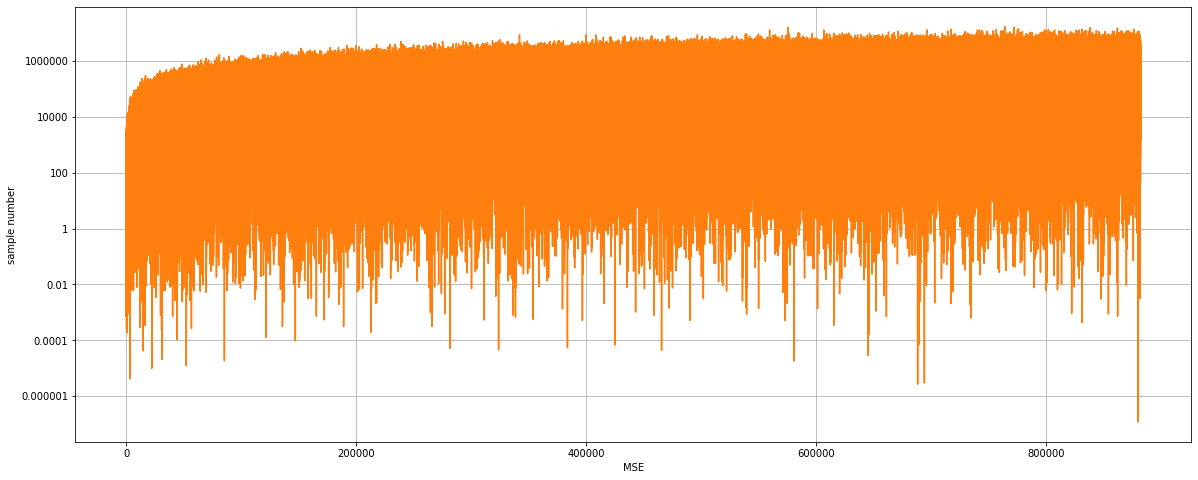

In [173]:
fig = plot_spectrum()
MSE_sin = MSE(e_sin, s)
plt.plot(MSE_sin)
plt.savefig('MSE_sinusoid_K10_sigma5')
plt.show()

We find the smallest sample after which all values are under the threshold using `find_smallest_samples`. The threshold is arbitrary. And then we compute the smallest sample for different values of $\mu$. 

In [52]:
#find smallest sample after which all values are under the threshold
def find_smallest_samples(mu_max, K, d, x, s, i,threshold):
    e_sin = normalized_lms(mu_max/i, K, d, x)
    MSE_sin = MSE(e_sin, s)
    return len(MSE_sin) - np.where(MSE_sin[::-1]>threshold)[0][0]

#get the list for different values of mu
def samples_thrs(mu_max, K, d, x, s,threshold=0.1, mu_div_range=range(10, 100000, 1000)):
    samples = np.zeros(len(mu_div_range))
    for count, i in enumerate(mu_div_range):
        samples[count] = find_smallest_samples(mu_max, K, d, x, s, i,threshold)
    return samples

Here is the plot that we get for the smallest sample after which all values are under thrsh as a function of $\mu$. We also find the best $\mu$ (the one giving the fastest convergence). 

In [53]:
def plot_spectrum_xlog(axis_bounds_x, xlabel, ylabel):
    fig, axs = plt.subplots(1, 1, figsize=(16, 8))
    axs.grid(True)
    axs.semilogx(10)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    plt.xlim(axis_bounds_x[0], axis_bounds_x[1])
    axs.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
    return axs

In [54]:
def draw_threshold_samples(K, s, noise, d):
    mu = max_mu(noise, K, 100) 
    samples = samples_thrs(mu, K, d, noise, s)
    
    plot_spectrum_xlog([mu/10, mu/100000], '$\mu$', 'sample number')
    plt.plot(mu/range(10, 100000, 1000), samples)
    title = 'Smallest sample number after which all samples are above the threshold as a function of $\mu$, for K = '+ str(K)+', and $\sigma$ = 1'
    plt.title(title)
    save_title = 'sample_graph_K'+ str(K) +'_sigma1.png'
    plt.savefig(save_title)
    plt.show()
    return (samples, mu/range(10, 100000, 1000))

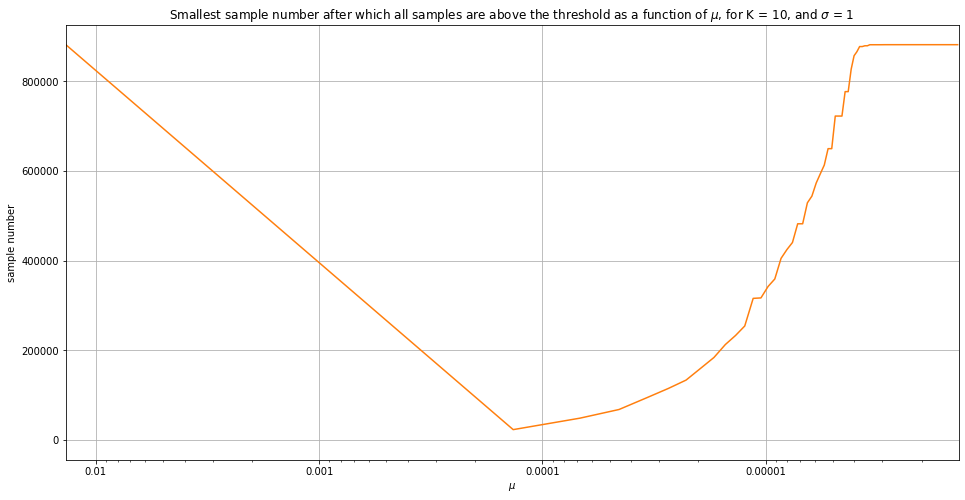

[0.00013504]


In [55]:
l = samplerate*20  
n = np.arange(l)
s = np.sin(n*2*np.pi * float(440)/samplerate)
x = np.random.normal(0, 1, l)
h = [-0.86101471,  0.39594833, -1.04287894, -1.00737516, -0.331485]
d = s + np.convolve(x, h)[:l]   

samples, mu = draw_threshold_samples(10, s, x, d)
print(mu[np.where(samples == np.min(samples))])

In [56]:
list(zip(samples, mu))

[(881993.0, 0.01363926301913188),
 (23230.0, 0.00013504220811021665),
 (48788.0, 6.785702994592975e-05),
 (68138.0, 4.531316617651788e-05),
 (94441.0, 3.401312473598973e-05),
 (115181.0, 2.7224077882498765e-05),
 (133732.0, 2.269428122983674e-05),
 (160661.0, 1.9456865933141057e-05),
 (184106.0, 1.7027794031375632e-05),
 (212989.0, 1.5137916780390545e-05),
 (233212.0, 1.3625637381750131e-05),
 (254425.0, 1.238806813726783e-05),
 (316052.0, 1.1356588692033207e-05),
 (317050.0, 1.0483676417472621e-05),
 (342684.0, 9.735376887317546e-06),
 (359263.0, 9.086784156650153e-06),
 (405271.0, 8.519214877658888e-06),
 (424895.0, 8.018379199959954e-06),
 (440673.0, 7.573161032277557e-06),
 (482450.0, 7.174783282026239e-06),
 (482450.0, 6.816223397867007e-06),
 (529239.0, 6.491795820624408e-06),
 (544178.0, 6.196848259487452e-06),
 (573418.0, 5.927537166072091e-06),
 (594067.0, 5.680659316589705e-06),
 (613464.0, 5.453523798133499e-06),
 (650045.0, 5.243853525233326e-06),
 (650045.0, 5.049708633517

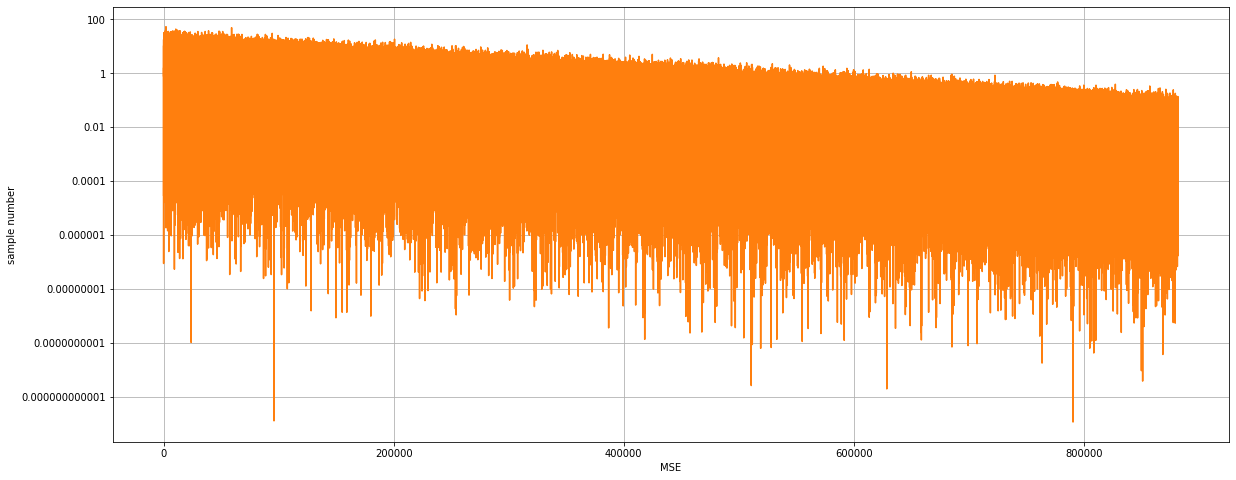

In [114]:
K=10
mu = 3.0647619742565576e-06
e_sin_lms = lms(mu, K, d, x)
MSE_sin_lms = MSE(e_sin_lms, s)

title = 'LeakyLMS_MSE_sigma1_normal_mu'
fig = plot_spectrum()
plt.plot(MSE_sin_lms)
plt.savefig(title)
plt.show()

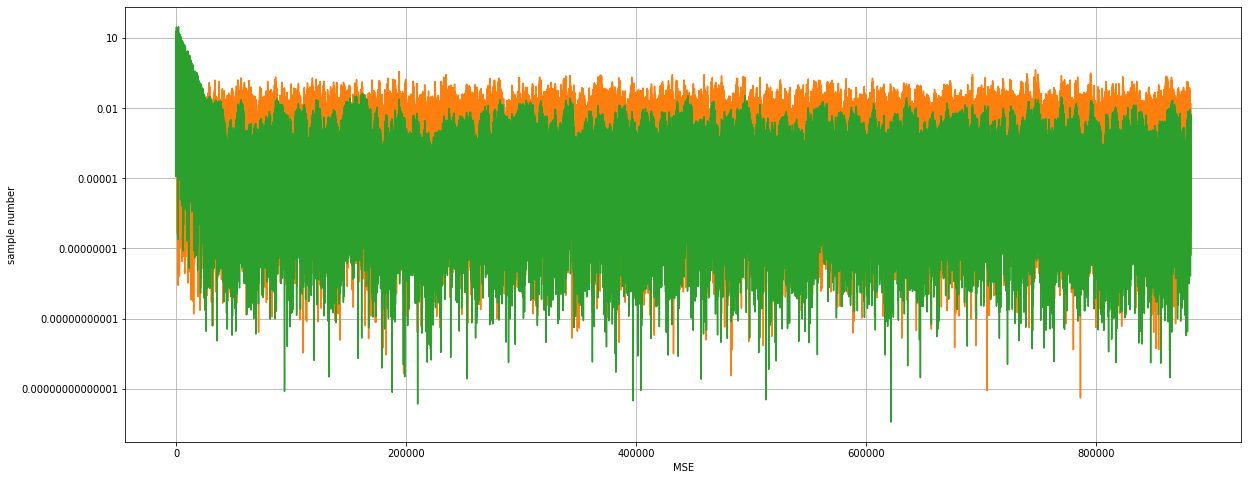

In [93]:
fig = plot_spectrum()
plt.plot(MSE_sin_leaky)
plt.plot(MSE_sin_lms)

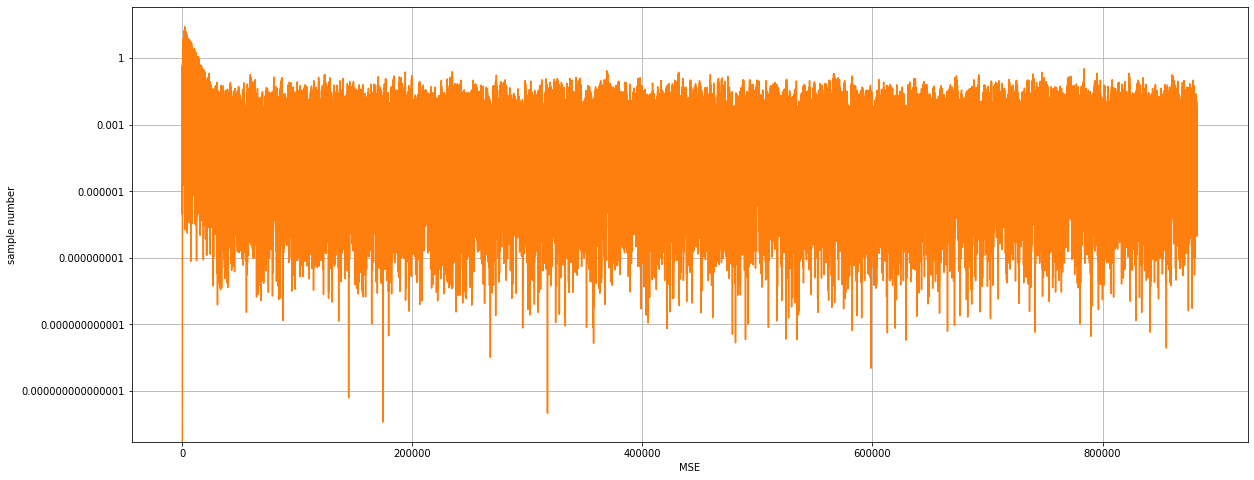

In [108]:
fig = plot_spectrum()
plt.plot(MSE(e_sin_lms, e_sin_normalized))

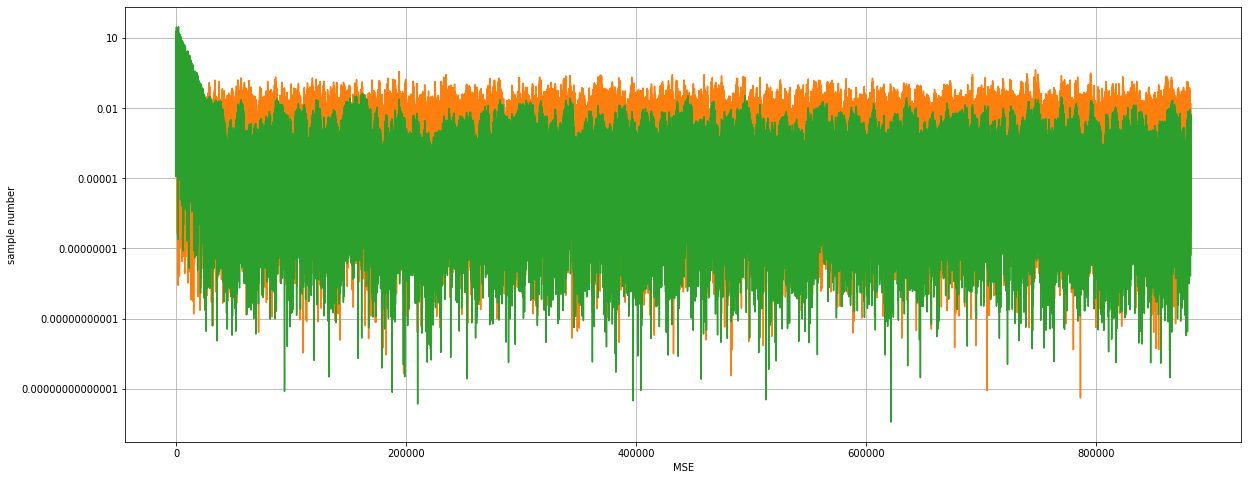

In [ ]:
fig = plot_spectrum()
plt.plot(MSE_sin_leaky)
plt.plot(MSE_sin_normalized)